# TITLE: Basic Modulation Concepts
Authors: ...
Last update: 17/11/2022

## Initialization

In [16]:
import os
import sys
import math
import numpy as np
from scipy.signal import welch
import matplotlib.pyplot as plt

current = os.getcwd()
parent = os.path.dirname(current)
sys.path.append(parent)

from PyDSP_core.TX.Tx_generateBits import Tx_generateBits, nextpow2
from PyDSP_core.TX.setSignalParams import setSignalParams
from PyDSP_core.TX.pulseShaper import pulseShaper
from PyDSP_core.TX.QAM_config import QAM_config
from PyDSP_core.TX.Tx_QAM import Tx_QAM

## Input Parameters

In [17]:
SIG = {
    'M': 64,            #QAM constellation size
    'symRate': 60e9,    #total symbol-rate of the signal
    'modulation': 'QAM',#modulation type [QAM/PAM]
    'rollOff': 0.1,     #roll-off factor
    'nPol': 1,          #number of polarizations
    'nSyms': pow(2, 17) #total number of simulated symbols
}
nSpS =  2               #number of samples per symbol

## Set Transmitter Parameters

In [18]:
#Signal Parameters:
TX = {'SIG': setSignalParams('symRate', SIG['symRate'], 'M', SIG['M'], 'nPol', SIG['nPol'],
                             'nBpS', math.log2(SIG['M']), 'nSyms', SIG['nSyms'],
                             'roll-off', SIG['rollOff'], 'modulation', SIG['modulation'])
}
#Modulation Parameters:
TX['QAM'] = QAM_config(TX['SIG'])
#Bit Parameters:
TX['BIT'] = {'source': 'randi',
             'seed': 1
}
#Pulse Shaping Filter Parameters:
TX['PS'] = {'type': 'RC',
            'rollOff': TX['SIG']['rollOff'],
            'nTaps': 128
}
#DAC Parameters:
TX['DAC'] = {'RESAMP': {'sampRate':nSpS * TX['SIG']['symRate']}
}

## Generate Tx Bits

In [19]:
TX['BIT']['txBits'] = Tx_generateBits(SIG['nSyms'], TX['QAM']['M'], TX['QAM']['nPol'], TX['BIT'])

## Generate Transmitted Symbols

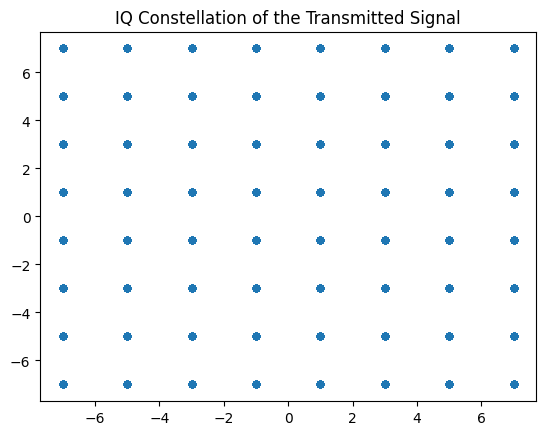

In [20]:
S = {}
S['tx'], TX['BIT']['txSyms'] = Tx_QAM(TX['QAM'], TX['BIT']['txBits'])

# Plot Transmitted Constellation Symbols:
plt.scatter(S['tx'].real, S['tx'].imag, s=20)
plt.title('IQ Constellation of the Transmitted Signal')
plt.show()

## Pulse Shaping

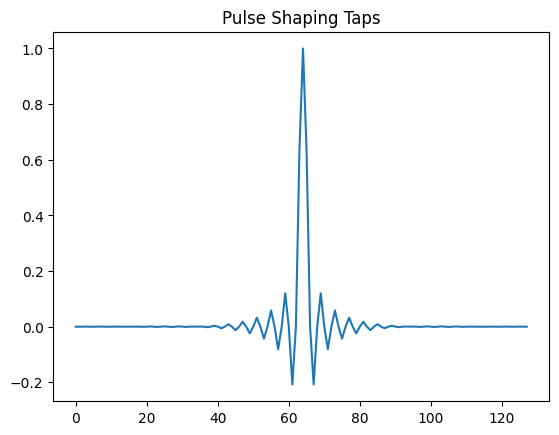

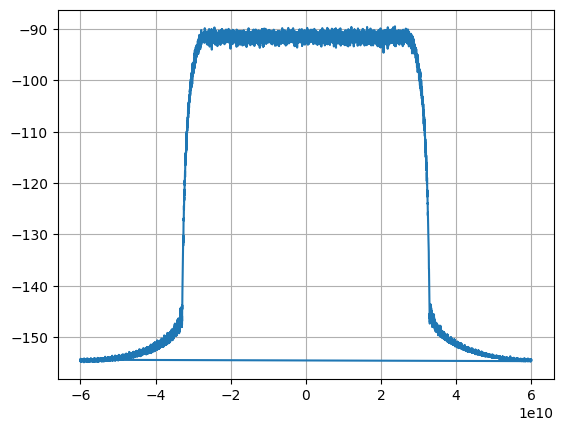

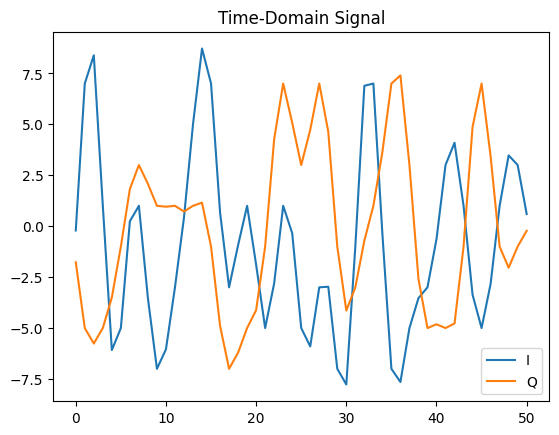

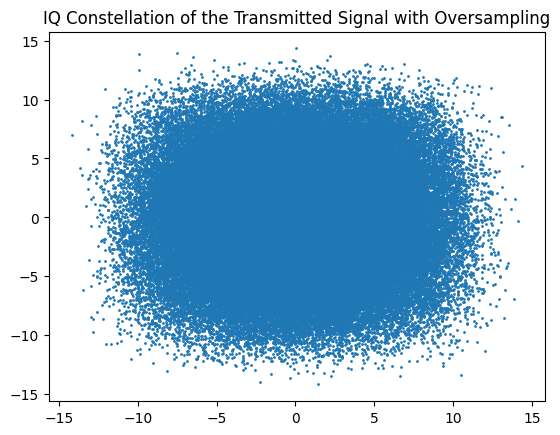

In [21]:
S['txSC'], TX['PS'] = pulseShaper(S['tx'], nSpS, TX['PS'])

#Plot Pulse Shaping Taps:
plt.plot(TX['PS']['W'])
plt.title('Pulse Shaping Taps')
plt.show()

# Plot Signal Spectrum:
# No matlab: pwelch(S.txSC(1,:),1e4,[],[],TX.DAC.RESAMP.sampRate,'centered')
#                  (x, window, noverlap, nfft, Fs, freqrange)
#
# window - If window is an integer, the signal is divided into segments of length window. The modified periodograms are computed using a Hamming window of length window.
# noverlap - If you do not specify noverlap, or specify noverlap as empty, the default number of overlapped samples is 50% of the window length.
# nfft - The default nfft is the greater of 256 or the next power of 2 greater than the length of the segments.

wind = np.hamming(pow(10,4))
nov = np.floor(pow(10,4)/2)
nff = max(256, pow(2,nextpow2(pow(10,4))))

f,Pxx = welch(S['txSC'][0],window = np.hamming(int(1e4)),noverlap=nov,nfft=nff,fs=TX['DAC']['RESAMP']['sampRate'],return_onesided=False ,detrend= False)
plt.plot(f,10*np.log10(Pxx))
plt.grid()
plt.show()

#Plot Time-Domain Signal:
ni = 49
nf = 100
plt.plot(S['txSC'][0,ni:nf].real)
plt.plot(S['txSC'][0,ni:nf].imag)
plt.legend(['I','Q'])
plt.title('Time-Domain Signal')
plt.show()

#Plot Time-Domain Signal Constellation with Oversampling:
plt.scatter(S['txSC'][0].real, S['txSC'][0].imag,s=1)
plt.title('IQ Constellation of the Transmitted Signal with Oversampling')
plt.show()

## Plot Time-Domain Signal Constellation after Downsampling

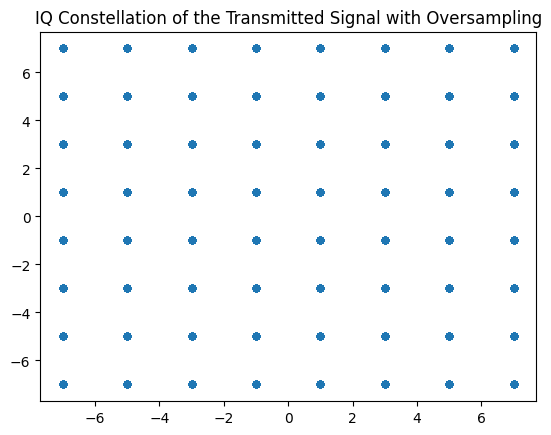

In [22]:
plt.scatter(S['txSC'][0,::nSpS].real, S['txSC'][0,::nSpS].imag, s=20)
plt.title('IQ Constellation of the Transmitted Signal with Oversampling')
plt.show()